<a href="https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Classification using BERT model

We are going to load pre-trained BERT model and fine-tune it for a spam classification.

### Prerequisits

### Install Transformers Library

Make sure that `transformers` package is installed on your machine. If not, go ahead and runthe following command to install it by `pip`.

In [2]:
!pip install transformers

     |████████████████████████████████| 1.3MB 8.2MB/s 
     |████████████████████████████████| 1.1MB 27.9MB/s 
     |████████████████████████████████| 2.9MB 41.5MB/s 
     |████████████████████████████████| 890kB 41.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b7d2fc5f6e2ac1378cbe84f80492101dbdd6f535fe7ec44e722420e2d208399e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Note: We would like to run this code on GPU. If you are using colab, check out the **Change Runtime Type** option in the **Runtime** menu, right above this text, to make sure that you are using a GPU on Google Colab.

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# 1. Data

### 1-1. Load Dataset

We are going to use the dataset provided in `spamdata_v2.csv` file. Make sure if the file is in the same path as this jupyter notebook. We import the dataset using `pandas` python package.

You can check some samples of the dataset by the `head()` function as follows. The **label** column shows the spam/not-spam class. zero means not-spam. 

In [4]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.shape

(5572, 2)

In [6]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

It is obvious that we are doing an **imbalanced classification**, meaning that if you consider all emails as **not-spam**, yet your accuracy is 86%, which is not bad ;)) 

### 1-2. Split Dataset

We use `train_test_split` from `scikit-learn` package to split dataset into train, validation and test sets.

#### **#Your_Job**
In the following cell, try to complete the second line similar to the first line such that the temp set is splitted 50-50 into validation and test sets. [This page](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) may help you.

Note that using `random_state` parameter with a fix integer value gaurantees that every time you run this code, you get the same splited sets. Moreover, `stratify` parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.

In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set, 50% each
val_text, test_text, val_labels, test_labels = ######### YOUR CODE HERE ##############


### 1-3. Tokenization

We import BERT Tokenizer from the [Hugging Face](https://huggingface.co/) `transformers` python package.
Check out the [help page](https://huggingface.co/transformers/model_doc/bert.html#berttokenizerfast) for further details on the `BertTokenizerFast` class.

In [9]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Before any further process, let's check if the model is working well. In the following cell, two sentences are given to the BERT Tokenizer with enabled padding. As the length of two samples in `text` are no the same, enough **PAD TOKEN** is added to the shorter one to have the same length. Padding is applied in the attention mask as well. Run the cell to see the value of `sent_id`.

In [10]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [11]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Again, before any further process, let's take a look at the statistics of data. We plot **the histogram of the length** of samples in the train set to find a reasonable `max_seq_len` for truncation. Please note that without input truncation, too much padding for batches containing outliers (too long sentences.) may affect the performance. 

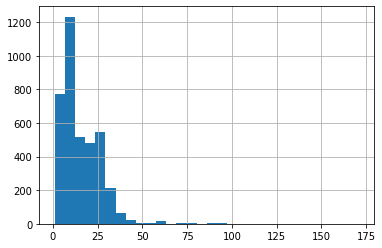

In [12]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

Now, we can **truncate** samples to `max_seq_len` and apply the BERT Tokenizer on train, val, and test sets.

In [13]:
max_seq_len = 25

In [14]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### 1-4. Convert to Tensors

Before feeding the data to the model, **integer sequences** should be cobverted into tensors.  

In [15]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### 1-5. DataLoaders

We create DataLoaders for train and validation sets for **automatic mini-batch processing**. The `DataLoader` class provides the Python iterable which is memory efficient. 

The `TensorDataset` wraps tensor such that each sample will be retrieved by indexing tensors along the first dimension. The `RandomSampler` class helps **shuffling** the train set; while in validation set, `SequentialSampler` is enough. 

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# 2. Model

### 2-1. Import BERT Model

We import BERT Pretrained model from the [Hugging Face](https://huggingface.co/) `transformers` python package. Click [here](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertmodel#transformers.BertModel) for more details on the BERT Model.

In [17]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

### 2-2. Freeze BERT Parameters

As our dataset is small, we do not like to ruin up every thing. So, we do not let the BERT parameters to be tuned in our spam classification task. Instead, we define two dense layers on top of the hidden state of the last layer for the `[CLS]` token. We hope training these two layers helps in our downstream task.

#### **#Your_Job**
Try to complete the following code such that the BERT parameters got frozen in the training phase.


In [18]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = ####### YOUR CODE HERE ########## (True or False)

### 2-3. Define Model Architecture

As usual, for defining the network architecture, we define a class inheriting from `torch.nn.Module`. Remember to overwrite `__init__` and `forward` fucntions for making the network architecture, and the forward pass, respectively. As you may know, the `__init__` function is called once when instantiating an object from the class, and `forward` function is called whenever you call the object for making the predictions.

In [19]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

You have defined the `BERT_Arch` class. Now, it is time to instantiate an object from the class and sent it to GPU.

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# 3. Training

### 3-1. Optimizer

We use `AdamW` optimizer from `transformers` package. If you are interested for more details of the *Decoupled Weight Decay Regularization* algorithm, implemented in the class, please refer to [this paper](https://arxiv.org/abs/1711.05101). 

In [21]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

### 3-2. Loss function

As the dataset is imbalance, we prefer to find Class Weights and feed them to the loss function for a fair error computation.

In [22]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.57743559 3.72848948]


In [23]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

### 3-3. Train Function

We fine-Tune our customized BERT architecture on the small supervised spam classificatiopn dataset. We review the train set for `epochs` times. You may refer to the Section **3-5. Start Model Training** for the main function of the training phase. In every epoch, we feed mini-batches to the network. With the frozen BERT parameters, we update the two dense layers defined on the top of the BERT model for our downstream task. The following `train()` function is in charge of computing the **average loss** and making the **predictions** for every epoch during the training.  


#### **#Your_Job**
Try to complete the following code for computing the cross entropy loss between actual and predicted values.

In [24]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = ###### YOUR CODE HERE ###############

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

### 3-4. Evaluate Function

In [25]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### 3-5. Start Model Training

In [30]:
# number of training epochs
epochs = 10

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.539
Validation Loss: 0.325

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.350
Validation Loss: 0.245

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.245
Validation Loss: 0.260

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.272
Validation Loss: 0.467

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.253
Validation Loss: 0.214

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.355
Validation Loss: 0.324

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.264
Validation Loss: 0.230

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.197
Validat

### 3-6. Load Saved Model

In [31]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# 4. Test

We should get predictions for test data (without updating parameters) to evaluation the trained model.  

In [32]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [33]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       724
           1       0.90      0.90      0.90       112

    accuracy                           0.97       836
   macro avg       0.94      0.94      0.94       836
weighted avg       0.97      0.97      0.97       836



In [34]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,713,11
1,11,101
